### source:
- [workshops examples](https://github.com/tensorflow/workshops) Recreate "Text classification example"
- [text-classification](https://developers.google.com/machine-learning/guides/text-classification/) Please follow the instruction to perform the work
- [basic_text_classification](https://www.tensorflow.org/tutorials/keras/basic_text_classification) Tutorial
- [text classification](https://medium.com/tensorflow/building-a-text-classification-model-with-tensorflow-hub-and-estimators-3169e7aa568)
- [keras meets universal sentence encoder transfer learning for textdata](https://www.dlology.com/blog/keras-meets-universal-sentence-encoder-transfer-learning-for-text-data/)
- [NMT with attention: do this tomorrow](https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb)
- [reading text-classification](https://blog.mimacom.com/text-classification/)

# Table of Contents
1. [jump to model](#model_sec)

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

W0529 23:28:44.551687  1448 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
# !pip install tensorflow_hub
# !pip install jupyter-tensorboard
print('The tensorflow version is {}.'.format(tf.__version__))

The tensorflow version is 1.13.1.


# Getting started

## Data
We will try to solve the hotel room classification problem as defined in previous section. The dataset consists of hotel room information labeled by various room features. The task is to label the rooms as **type**, **beding**, **view**, **location**, **accessibility**, **policy**, **meal option**, **fee option**, etc.

In [3]:
from clean_data import *

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\XUN_2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\XUN_2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\XUN_2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
source_file_name = 'rooms_data_combined.csv'

raw_data = \
     pd.read_csv(source_file_name, usecols=['hotel_id', 'room_name', 'value_adds','combined','labels'], \
                 dtype= { "hotel_id":np.uint8, "room_name": np.character, "value_adds":np.character, 'combined':np.character,'labels':np.character})

In [8]:
# raw_data = raw_data[pd.notnull(raw_data['room_name'])]
# raw_data = raw_data[['hotel_id', 'room_name', 'value_adds']]

In [9]:
# raw_data.columns.tolist()
raw_data.count()

hotel_id      1432091
room_name     1432091
value_adds    1432091
combined       354785
labels        1431112
dtype: int64

In [10]:
# raw_data.to_csv('./original_rooms_data.csv', index=False)
raw_data.head()

,hotel_id,room_name,value_adds,combined,labels
0,96,"Double Room,Ensuite","Free Wireless Internet,Full Breakfast,UKN",NaN,rmf_free_internet prmf_free_breakfast bdc_1 bd...
1,96,Double-Standard-Ensuite with Shower-Large R5,"Free Parking,Free Wireless Internet,Full Break...",large r5,rmf_free_internet prmf_free_breakfast bdc_1 bd...
2,97,2 Queen 1 Bedroom Suite - Free Breakfast - Fri...,UKN,NaN,prmf_free_breakfast rmf_frig rmf_microwave bdc...
3,97,"Suite,1 King Bed,Accessible,Bathtub","Breakfast Buffet,NRF",NaN,rtf_nrf prmf_free_breakfast rmf_accessible_bat...
4,97,"Suite,1 King Bed,Accessible (Hearing)","Breakfast Buffet,NRF",NaN,rtf_nrf prmf_free_breakfast rmf_accessible_hea...


### combine room and value adds into a new column

In [36]:
from update_data import *

In [37]:
# raw_data['combined'] = np.vectorize(combine)(raw_data['room_name'], raw_data['value_adds'])
# raw_data.head()
# raw_data.loc[1373878]
pd.set_option('display.max_colwidth', -1)

In [ ]:
raw_data.loc[(raw_data['combined'].str.contains('ada')) & (pd.notnull(raw_data['combined']))]
# raw_data.loc[(raw_data['labels'].str.contains('rtf_single_use'))]


# selected_categories = [
#  'rmt_mini', 'rmt_premium', rmt_standard', 'rmt_delux', 'rmt_superior', 'rmt_grand', 'rmt_studio', 'rmt_parlor', 'rmt_non_suite', 'rmt_suite', 'rmt_bedroom', 'rmt_club', 'rmt_twin', 'rmt_triple', 'rmt_quadruple', 'rmt_room','rmt_villa','rmt_penthouse', 'rmt_apartment', 'rmt_dorm', 'rmt_key_word', 'rmt_cabin', 'rmt_cottage','rmt_residence', 'rmt_title', 'rmt_bungalow', 'rmt_pod',
#  'rmc_1', 'rmc_2', 'rmc_3', 'rmc_4', 'rmc_more',
#  'bdt_double', 'bdt_twin', 'bdt_queen', 'bdt_king','bdt_single','bdt_sofa_bed','bdt_single_sofa_bed','bdt_single_bed','bdt_full_bed','bdt_bunk_bed',
#  'bdc_1', 'bdc_2', 'bdc_3', 'bdc_4', 'bdc_more',
#  'prmf_all_inclusive', 'prmf_all_inclusive_lite', 'prmf_all_inclusive_semi','prmf_welcome_item','rtf_free_parking',
#  'rmv_standard', 'rmv_good', 'rmv_better', 'rmv_best','rmv_non',
#  'rml_hiflr', 'rml_loflr', 'rml_loft', 'rml_tower', 'rml_pool_spa_access','rml_direct_access','rml_special_space_access','rml_concierge_level','rml_lmited_or_no_access', 'rml_special_flr', 'rml_garden_area','rml_annex_building',
#  'rmf_accessible', 'rmf_smoking', 'rmf_no_smoking', 'rmf_full_kitchen', 'rmf_kitchenette', 'rmf_balcony', 'rmf_terrace', 'rmf_extra_bedding','rmf_mini_frig','rmf_frig','rmf_microwave','rmf_allergy_friendly','rmf_single_use','rmf_pet_friendly','rmf_traditional','rmf_free_internet',
#   'rmf_accessible_mobility', 'rmf_accessible', 'rmf_smoking', 'rmf_no_smoking','rmf_no_ac',
#  'rtf_free_cxl', 'rtf_nrf', 'rtf_fee_included', 'rtf_other_item_or_credit_included', 'rtf_free_transport', 'rtf_acctivity_included',
#  'prmf_free_breakfast', 'prmf_free_dinner', 'prmf_free_lunch', 'prmf_free_buffet', 'prmf_half_board', 'prmf_full_board', 'prmf_all_inclusive', 'prmf_all_inclusive_lite', 'prmf_all_inclusive_semi', 'prmf_welcome_item', 'prmf_promotional']


In [16]:
raw_data.to_csv('./rooms_data_combined.csv', index=False)

In [65]:
raw_data.loc[188935]

hotel_id      88                                                                              
room_name     Studio,2 Double Beds,No View: No Resort Fees. No Hidden Charges. No Parking Fee.
value_adds    NRF                                                                             
combined      resort fee hide charge park fee                                                 
labels        rtf_nrf bdc_2 bdt_double rmt_studio rtf_free_transport rmv_standard rmt_title   
Name: 188935, dtype: object

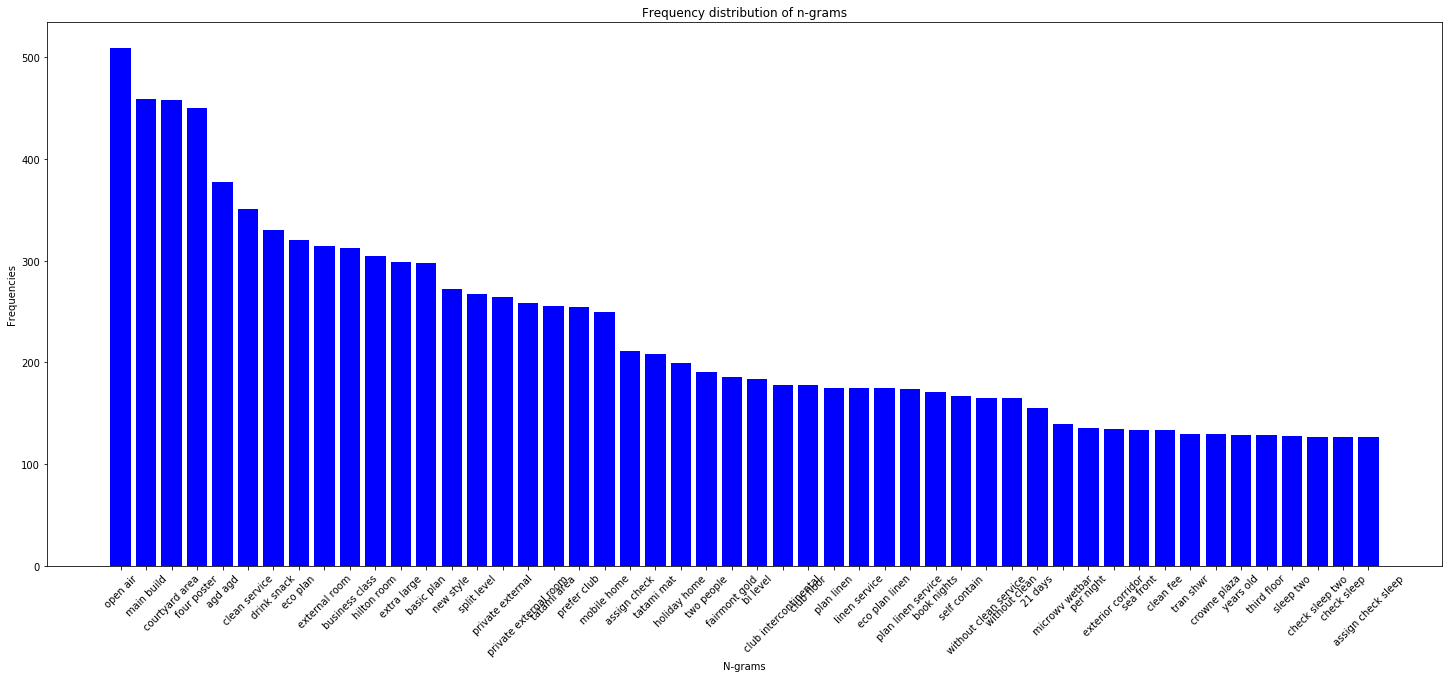

In [17]:
from explore_data import plot_frequency_distribution_of_ngrams

plt.figure(figsize = (25,10))
plot_frequency_distribution_of_ngrams(raw_data.loc[pd.notnull(raw_data['combined'])].combined, ngram_range=(2, 3))

In [ ]:
# add_label_by_column_name(raw_data, 'room_name', 'Room|ROOM|room', 'rmt_room')
# raw_data = raw_data[pd.notnull(raw_data['labels'])]
# clean_label_by_column_name(raw_data, 'labels', 'bdt_sinlge', 'bdt_sinlge', 'bdt_single')
# clean_label_by_column_name(raw_data, 'labels', 'bdt_sofa_bed', 'bdt_sofa_bed', 'bdt_sofabed')
# clean_label_by_column_name(raw_data, 'labels', 'bdt_single_sofa_bed', 'bdt_single_sofa_bed', 'bdc_1 bdt_sofabed')
# clean_label_by_column_name(raw_data, 'labels', 'bdt_sinlgeitle', 'bdt_sinlgeitle', 'bdt_single rmt_title')
# clean_label_by_column_name(raw_data, 'labels', 'bdc_4', 'bdc_4', 'bdc_more')
# clean_label_by_column_name(raw_data, 'labels', 'rmc_4', 'rmc_4', 'rmc_more')

# clean_label_by_column_name(raw_data, 'labels', 'rmf_accessible_mobility|rmf_accessible_bath|rmf_accessible_hear', 'rmf_accessible_mobility|rmf_accessible_bath|rmf_accessible_hear', 'rmf_accessible')
# clean_label_by_column_name(raw_data, 'labels', 'rmf_single_use', 'rmf_single_use', 'rmt_single')


remove_dup_labels(raw_data)
raw_data.head()

In [49]:
# raw_data['name'] = raw_data['room_name'].str.cat(raw_data['value_adds'],sep=" ")

# raw_data.drop('room_name', axis=1, inplace=True)
# raw_data.drop('value_adds', axis=1, inplace=True)
# raw_data = raw_data[['hotel_id', 'name', 'labels']]

# raw_data['name'] = raw_data['name'].str.replace('UKN','')
# raw_data.columns = ['hotel id', 'room_name', 'labels']
# raw_data.head()
raw_data.shape


(1432071, 3)

In [51]:
# raw_data.drop('combined', axis=1, inplace=True)
# raw_data.head()
# raw_data.to_csv('./source_data_labeled.csv', index=False)
data_df.to_csv('./source_data_labeled.csv', index=False)

In [ ]:
from collections import Counter
Counter(" ".join(raw_data["labels"]).split()).most_common(100)

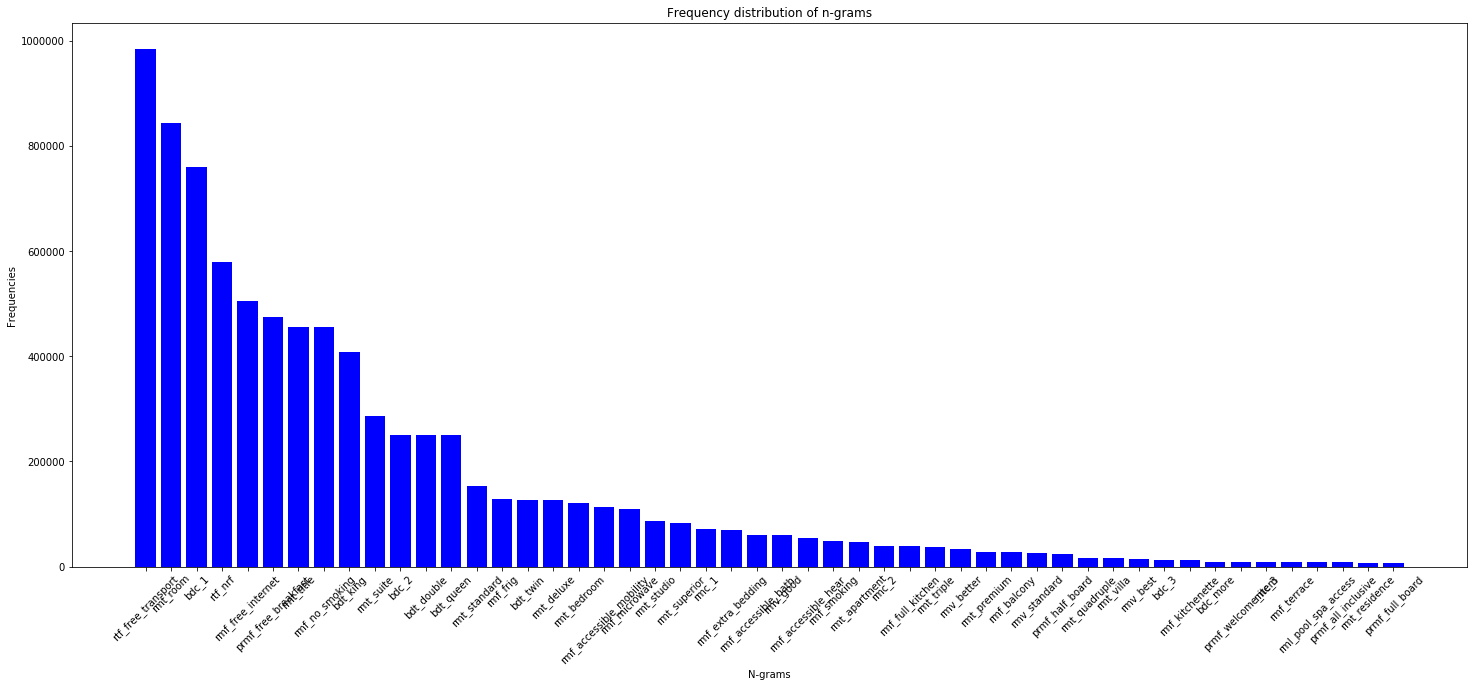

In [27]:
from explore_data import plot_frequency_distribution_of_ngrams

plt.figure(figsize = (25,10))
plot_frequency_distribution_of_ngrams(raw_data.loc[pd.notnull(raw_data['labels'])].labels, ngram_range=(1, 1))

In [ ]:
# raw_data.loc[raw_data['labels'].str.contains('rmf_no_smoking'), 'combined'] = raw_data.loc[raw_data['labels'].str.contains('rmf_no_smoking'), 'combined'].str.replace('smok','')
raw_data.loc[raw_data['labels'].str.contains('rtf_nrf'), 'combined'] = raw_data.loc[raw_data['labels'].str.contains('rtf_nrf'), 'combined'].str.replace(' nrf','')
raw_data.loc[raw_data['labels'].str.contains('rtf_nrf'), 'combined'] = raw_data.loc[raw_data['labels'].str.contains('rtf_nrf'), 'combined'].str.replace('non refundable','')
raw_data.head()

In [ ]:
for key, value in dict_labels.items():
    if key in raw_data['combined']:
        raw_data['combined'].replace(key,'')

In [ ]:
# rdx = 1
# long_name = raw_data.iloc[rdx]['room_name']
# if pd.notnull(raw_data.iloc[rdx]['value_adds']):
#     long_name = long_name + ' ' + raw_data_feed.iloc[rdx]['value_adds']
# print(long_name)
# print(word_tokenize(long_name))
# dataframe["combined"] = dataframe['room_name'] + dataframe["value_adds"]

In [ ]:
# uncomment the following to read all the data
# raw_data_feed = \
#     pd.read_csv('hotel_data_all_raw.csv', \
#                 dtype= {"vendor_key": np.character, "vendor_id": np.character, \
#                         "hotel_name": np.character, "room_name": np.character, \
#                         "price_display": np.float16, "value_adds":np.character, "hotel_id":np.uint8})

# read only the room_name for now

preprocessed_data = False
if os.path.exists('hotel_data_all_preprocessed.csv'):
    raw_data_feed = \
        pd.read_csv('hotel_data_all_preprocessed.csv', usecols=['room_name', 'value_adds', 'hotel_id'], \
                    dtype= { "room_name": np.character, "value_adds":np.character, "hotel_id":np.uint8})
    preprocessed_data = True
else:
    raw_data_feed = \
        pd.read_csv('hotel_data_all_raw.csv', usecols=['room_name', 'value_adds', 'hotel_id'], \
                    dtype= { "room_name": np.character, "value_adds":np.character, "hotel_id":np.uint8})

raw_data_feed.head()
raw_data_feed.room_name.head()

In [ ]:
# raw_data_feed[pd.isnull(raw_data_feed['room_name'])]
raw_data_feed[raw_data_feed['room_name'].str.len()>200]
# loc = raw_data_feed.iloc[max(raw_data_feed['room_name'].str.len())]
# print(loc)

In [21]:
print(raw_data_feed.room_name[373716])
print(len(raw_data_feed.room_name[373716]))

standard double room
20


In [ ]:
# remove rows missing room name
raw_data_feed = raw_data_feed[pd.notnull(raw_data_feed['room_name'])]
raw_data_feed.head()

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')

rdx = 1
long_name = raw_data_feed.iloc[rdx]['room_name']
if pd.notnull(raw_data_feed.iloc[rdx]['value_adds']):
    long_name = long_name + ' ' + raw_data_feed.iloc[rdx]['value_adds']
print(long_name)
print(word_tokenize(long_name))

In [8]:
value_adds_data_feed = raw_data_feed[pd.notnull(raw_data_feed['value_adds'])]

if not preprocessed_data:
    raw_data_feed['room_name'] = raw_data_feed['room_name'].apply(text_preprocess)
    raw_data_feed['value_adds'] = raw_data_feed['value_adds'].apply(text_preprocess)
    raw_data_feed.to_csv('./hotel_data_all_preprocessed.csv', index=False)
else:
    raw_data_feed['room_name'] = raw_data_feed['room_name'].apply(remove_stop_words)


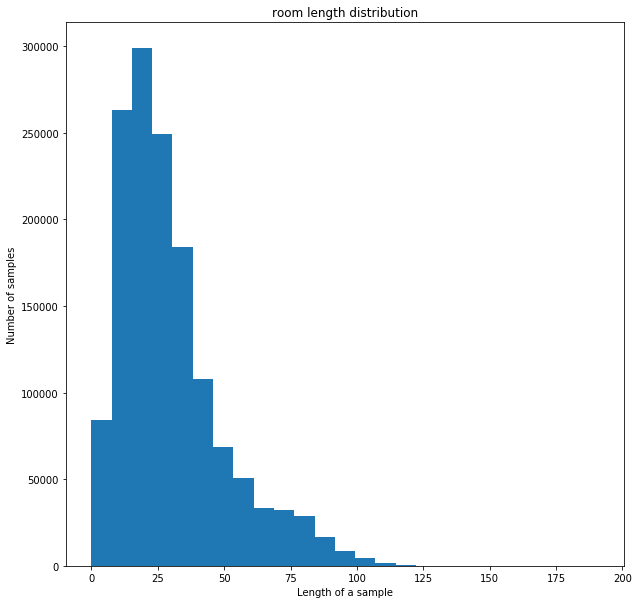

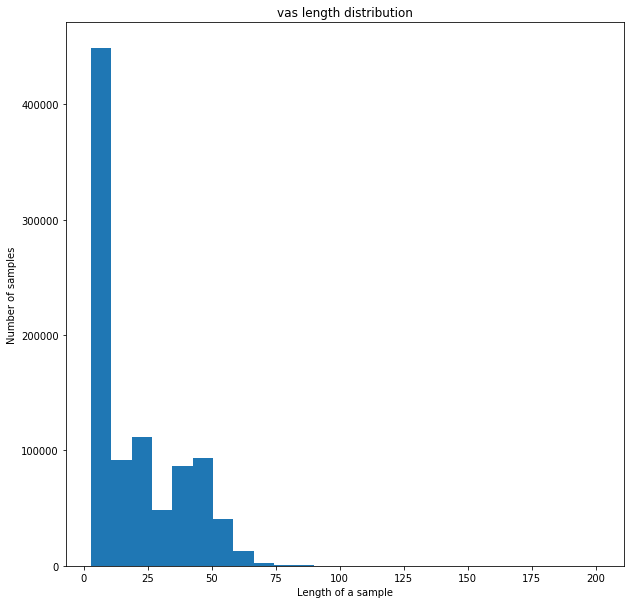

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from explore_data import get_num_words_per_sample
from explore_data import plot_sample_length_distribution

plt.figure(figsize = (10,10))
plot_sample_length_distribution(raw_data_feed.room_name, "room")

plt.figure(figsize = (10,10))
plot_sample_length_distribution(value_adds_data_feed.value_adds, "vas")

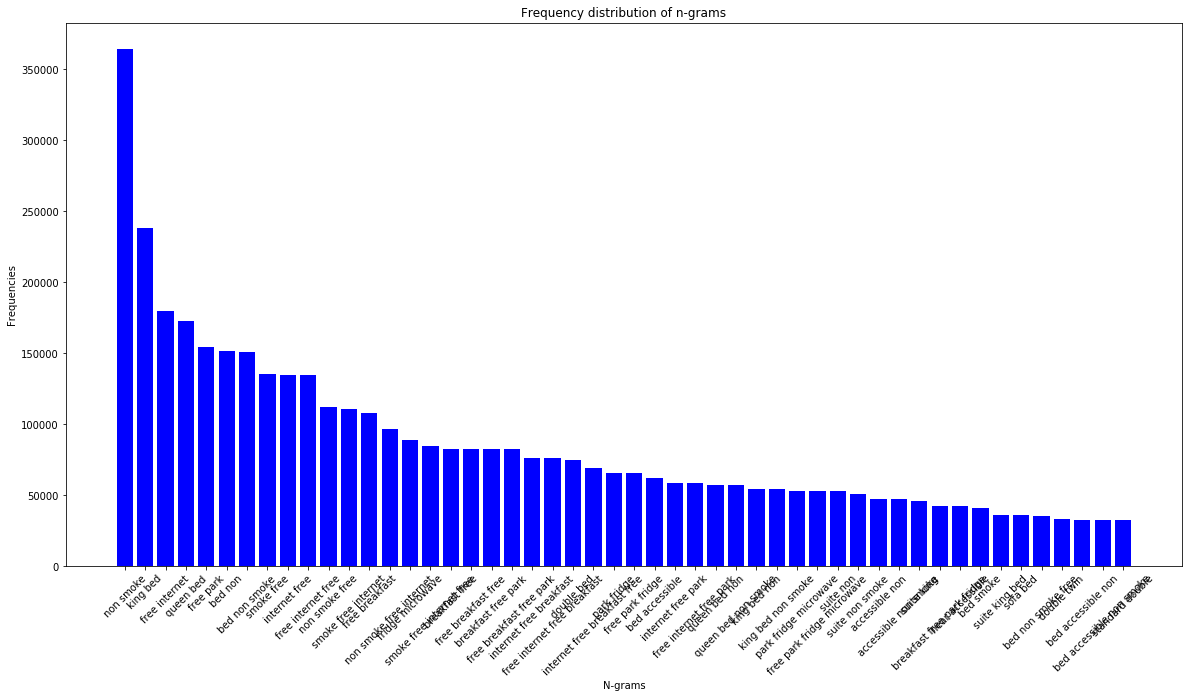

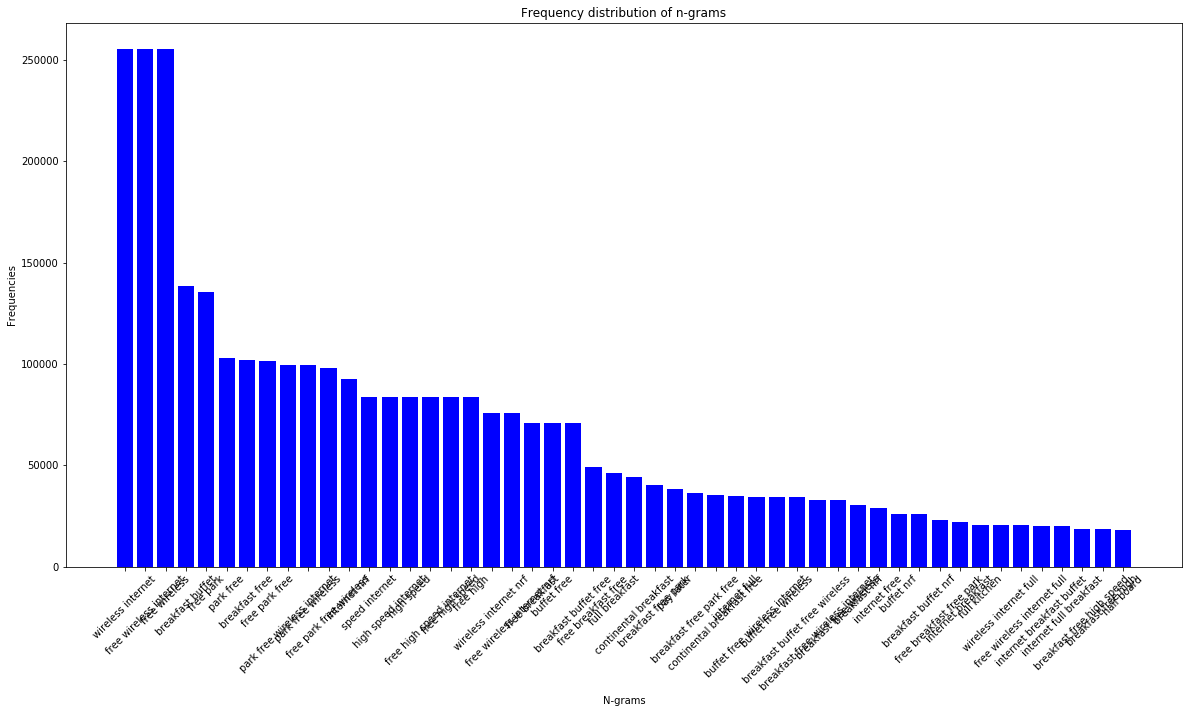

In [12]:
from explore_data import plot_frequency_distribution_of_ngrams

plt.figure(figsize = (20,10))
plot_frequency_distribution_of_ngrams(raw_data_feed.room_name, ngram_range=(2, 4))

plt.figure(figsize = (20,10))
plot_frequency_distribution_of_ngrams(value_adds_data_feed.value_adds, ngram_range=(2, 4))

#### Word Cloud Plot
Let us see what are the common words used for room name

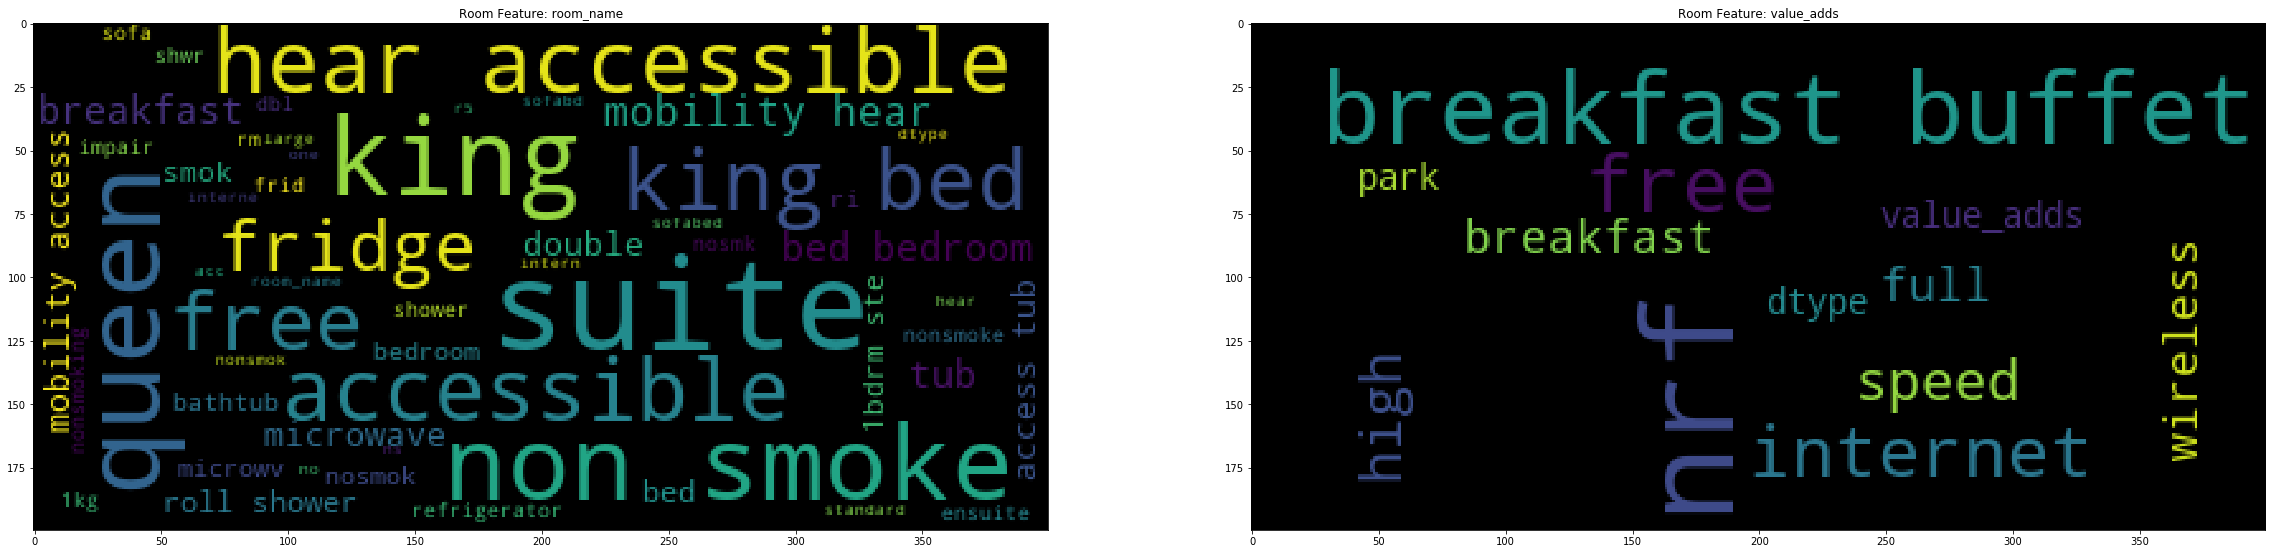

In [42]:
def save_wordcloud_plots(data, cols):
    for idx, col in enumerate(category_columns):
        wordcloud = WordCloud(max_font_size=50).generate(str(raw_data_feed[col]))
        ax = plt.figure(figsize=(20, 60)).add_subplot(1, 1, 1)
        ax.imshow(wordcloud)
        ax.axis("off")
        ax.set(title='Room Feature: {0}'.format(col))
        plt.savefig('./images/wordcloud_{0}.png'.format(col), bbox_inches='tight')
        plt.close()
        
category_columns = ('room_name','value_adds')

if not os.path.exists('./images/wordcloud_rooms.png'):
    save_wordcloud_plots(raw_data_feed, category_columns)
    
fig = plt.figure(figsize=(40, 120))
num_cols = 2
num_rows = np.ceil(len(category_columns)/num_cols)
for idx, col in enumerate(category_columns):
    wordcloud = WordCloud(max_font_size=50,stopwords = ['NaN','Length','object','name']).generate(str(raw_data_feed[col]))
    ax = fig.add_subplot(num_rows, num_cols, idx+1)
    ax.imshow(wordcloud)
    ax.axis("on")
    ax.set(title='Room Feature: {0}'.format(col))
plt.show()

### Features

| category | types | feature key |
| --- | --- | --- |
| room type | standard, deluxe, superior, premium, studio, suite, bedroom, club | rmt_ |
| room count | 1,2,3,... | rmc_ |
| bed type | double, twin, queen, king | bdt_ |
| bed count | 1,2,3,4,5,6,+ | bdc_ |
| room view | ocean, city, lake, garden, beach, strip, panoramic, valley, mountain, courtyard, marina, harbour, park, pool, canal, atrium, generic, landmark | rmv_ |
| room location | front, tower, high/upper floor, lower floor, special access | rml_ |
| room features | with decorated name, mobility/hearing accessible, smoking, none smoken, free internet, full kitchen, kitchenette, balcony, terrace | rmf_ |
| rate features | free cancellation, non-refundable, resort fee included, xyz items/fees included | rtf_ |
| promotional feature | free breakfast, free buffet, all-inclusve, all-inclusive-lite, half-board, full-board, welcome item | prmf_ |
| payment options | pre-pay, pay-later | payo_ |

### Targeting Features

| category | types | prefix |
| --- | --- | --- |
| room type | room,  suite, standard, deluxe, bedroom, studio, superior, apartment, single, triple, premium, quadruple, villa, residence, bungalow, cottage, dorm, nonsuite, title, mini, delux, penthouse, parlor, twin | rmt_ |
| room count | 1,2,3, more | rmc_ |
| bed type | king, double, queen, twin, single, full, sofabed | bdt_ |
| bed count | 1,2,3, more | bdc_ |
| room view | good, standard, better, best, non  | rmv_ |
| room location | pool_spa_access,hiflr,direct_access,special_space_access,loflr,garden_area,special_flr,annex_building,concierge_level,outdoor_access,loft,special_access,lmited_or_no_access | rml_ |
| room features | accessible, free_internet, no_smoking, frig, extra_bedding, smoking, full_kitchen, balcony, kitchenette, terrace, traditional, mini_frig, pet_friendly, allergy_friendly, no_ac, pet_not_allow | rmf_ |
| rate features | free_transport, nrf(non-refundable), other_item_or_credit_included, fee_included, free_parking, acctivity_included| rtf_ |
| promotional feature | free_breakfast,half_board,welcome_item,all_inclusive,full_board,free_dinner,promotional,free_lunch,breakfast_credit,all_inclusive_semi | prmf_ |

In [19]:
# Those are the top 50+ categories we will use for the classification
selected_categories = [
 'rmt_mini', 'rmt_premium', 'rmt_standard', 'rmt_delux', 'rmt_superior', 'rmt_grand', 'rmt_studio', 'rmt_parlor', 'rmt_non_suite', 'rmt_suite', 'rmt_bedroom', 'rmt_club', 'rmt_twin', 'rmt_triple', 'rmt_quadruple', 'rmt_room','rmt_villa','rmt_penthouse', 'rmt_apartment', 'rmt_dorm', 'rmt_key_word', 'rmt_cabin', 'rmt_cottage','rmt_residence', 'rmt_title', 'rmt_bungalow', 'rmt_pod',
 'rmc_1', 'rmc_2', 'rmc_3', 'rmc_4', 'rmc_more',
 'bdt_double', 'bdt_twin', 'bdt_queen', 'bdt_king','bdt_single','bdt_sofa_bed','bdt_single_sofa_bed','bdt_single_bed','bdt_full_bed','bdt_bunk_bed',
 'bdc_1', 'bdc_2', 'bdc_3', 'bdc_4', 'bdc_more',
 'prmf_all_inclusive', 'prmf_all_inclusive_lite', 'prmf_all_inclusive_semi','prmf_welcome_item','rtf_free_parking',
 'rmv_standard', 'rmv_good', 'rmv_better', 'rmv_best','rmv_non',
 'rml_hiflr', 'rml_loflr', 'rml_loft', 'rml_tower', 'rml_pool_spa_access','rml_direct_access','rml_special_space_access','rml_concierge_level','rml_lmited_or_no_access', 'rml_special_flr', 'rml_garden_area','rml_annex_building',
 'rmf_accessible', 'rmf_smoking', 'rmf_no_smoking', 'rmf_full_kitchen', 'rmf_kitchenette', 'rmf_balcony', 'rmf_terrace', 'rmf_extra_bedding','rmf_mini_frig','rmf_frig','rmf_microwave','rmf_allergy_friendly','rmf_single_use','rmf_pet_friendly','rmf_traditional','rmf_free_internet',
  'rmf_accessible_mobility', 'rmf_accessible', 'rmf_smoking', 'rmf_no_smoking','rmf_no_ac',
 'rtf_free_cxl', 'rtf_nrf', 'rtf_fee_included', 'rtf_other_item_or_credit_included', 'rtf_free_transport', 'rtf_acctivity_included',
 'prmf_free_breakfast', 'prmf_free_dinner', 'prmf_free_lunch', 'prmf_free_buffet', 'prmf_half_board', 'prmf_full_board', 'prmf_all_inclusive', 'prmf_all_inclusive_lite', 'prmf_all_inclusive_semi', 'prmf_welcome_item', 'prmf_promotional']

# Getting started
<a id="model_sec"></a>

## Data
We will try to solve the [Large Movie Review Dataset v1.0](http://ai.stanford.edu/~amaas/data/sentiment/) task from Mass et al. The dataset consists of IMDB movie reviews labeled by positivity from 1 to 10. The task is to label the reviews as **negative** or **positive**.

In [4]:
from sklearn.model_selection import train_test_split

def load_project_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="source_data_labeled.zip", 
      origin="https://github.com/x-wing/initial_exploration/raw/master/source_data_labeled.zip", 
      cache_subdir='data',
      extract=True,
      cache_dir="./")
  
  df_data = \
     pd.read_csv(dataset, usecols=['hotel id', 'room_name','labels'], \
                 dtype= { "hotel_id":np.uint8, "room_name": np.character,'labels':np.character})

  return df_data


# the dataset files. MultiLabelBinarizer
def split_datasets(data, test_size=0.2):
    return train_test_split(data, test_size, shuffle=true)

def split_datasets_with_labels(x, y, t_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=t_size, shuffle=True)
    return x_train, x_test, y_train, y_test


In [5]:
# Reduce logging output.
# tf.logging.set_verbosity(tf.logging.ERROR)

data_df = load_project_datasets()
# data_df = data_df.sample(frac=0.10)
data_df.head()

,hotel id,room_name,labels
0,96,"Double Room,Ensuite Free Wireless Internet,Ful...",rmf_free_internet prmf_free_breakfast bdc_1 bd...
1,96,Double-Standard-Ensuite with Shower-Large R5 F...,rmf_free_internet prmf_free_breakfast bdc_1 bd...
2,97,2 Queen 1 Bedroom Suite - Free Breakfast - Fri...,prmf_free_breakfast rmf_frig rmf_microwave bdc...
3,97,"Suite,1 King Bed,Accessible,Bathtub Breakfast ...",rtf_nrf prmf_free_breakfast rmf_accessible bdc...
4,97,"Suite,1 King Bed,Accessible (Hearing) Breakfas...",rtf_nrf prmf_free_breakfast rmf_accessible bdc...


#### rooms in each catagory

In [6]:
from collections import Counter
number_of_class = 10
top_labels = Counter(" ".join(data_df["labels"]).split()).most_common(number_of_class)
labels_dict = dict(top_labels)
labels = labels_dict.keys()
use_selected_labels = True

#### categories are of major interests

In [7]:
selected_labels = [ 
    'rmt_title', 'rmt_suite', 'rmt_standard', 'rmt_deluxe','rmt_bedroom','rmt_studio','rmt_superior','rmt_apartment','rmt_triple','rmt_premium','rmt_quadruple','rmt_villa','rmt_bungalow','rmt_cottage','rmt_single','rmt_dorm',
    'rmt_non_suite', 'rmt_residence', 'rmt_room',
    'bdt_king', 'bdt_double', 'bdt_queen', 'bdt_twin','bdt_single','bdt_full',
    'bdc_more', 'rmc_more',
    'prmf_free_breakfast','prmf_half_board','prmf_welcome_item','prmf_all_inclusive','prmf_full_board','prmf_free_dinner',
    'rtf_other_item_or_credit_included','rtf_fee_included','rtf_free_parking',
    'rmf_no_smoking','rmf_accessible','rmf_extra_bedding','rmf_smoking','rmf_balcony','rmf_terrace',
    'rmv_good','rmv_better','rmv_standard','rmv_best','rmv_non']

In [8]:
top100_labels = Counter(" ".join(data_df["labels"]).split()).most_common(100)
top100_labels_dict = dict(top100_labels)

In [9]:
top100_labels_dict

{'rtf_free_transport': 985253,
 'rmt_room': 845086,
 'bdc_1': 760461,
 'rtf_nrf': 579243,
 'rmf_free_internet': 506354,
 'prmf_free_breakfast': 474100,
 'rmt_title': 456324,
 'rmf_no_smoking': 455891,
 'bdt_king': 409322,
 'rmt_suite': 286942,
 'bdc_2': 250812,
 'bdt_double': 250701,
 'bdt_queen': 250519,
 'rmf_accessible': 164333,
 'rmt_standard': 154203,
 'rmf_frig': 128298,
 'bdt_twin': 127385,
 'rmt_deluxe': 127205,
 'rmt_bedroom': 121169,
 'rmf_microwave': 109479,
 'rmt_studio': 87158,
 'rmt_superior': 83345,
 'rmc_1': 71661,
 'rmf_extra_bedding': 69405,
 'rmv_good': 59233,
 'rmf_smoking': 48351,
 'rmt_apartment': 47481,
 'rmc_2': 39157,
 'rmf_full_kitchen': 38347,
 'rmt_triple': 37146,
 'rmv_better': 34202,
 'rmt_premium': 28354,
 'rmf_balcony': 28163,
 'rmv_standard': 26663,
 'prmf_half_board': 23348,
 'rmt_quadruple': 16742,
 'rmt_villa': 16667,
 'rmv_best': 13716,
 'bdc_3': 12617,
 'bdt_single': 11702,
 'rmf_kitchenette': 11623,
 'bdc_more': 9773,
 'prmf_welcome_item': 9142,
 

In [10]:
# categories = list(top100_labels_dict.keys())
# sns.set(font_scale = 2)
# plt.figure(figsize=(15,8))
# ax= sns.barplot(categories, top100_labels_dict.values)
# plt.title("Comments in each category", fontsize=24)
# plt.ylabel('Number of rooms', fontsize=18)
# plt.xlabel('Type ', fontsize=18)
# #adding the text labels
# rects = ax.patches
# labels = top100_labels_dict.values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
# plt.show()

In [11]:
# clean_label_by_column_name(data_df, 'labels', 'rmt_deluxee', 'rmt_deluxee', 'rmt_deluxe')
# print(lable_categoris)
# print(labels_dict['bdt_queen'])
# remove_dup_labels(data_df)

In [12]:
print(list(labels))

['rtf_free_transport', 'rmt_room', 'bdc_1', 'rtf_nrf', 'rmf_free_internet', 'prmf_free_breakfast', 'rmt_title', 'rmf_no_smoking', 'bdt_king', 'rmt_suite']


In [13]:
# pd.set_option('display.max_colwidth', -1)
# tmp_df = data_df[data_df["labels"].str.contains('rmt_key_word')]
# tmp_df.head()
# tmp_df = data_df.labels.unique()
# print(len(tmp_df))

In [14]:
data_label_df = data_df["labels"].str.split()

In [15]:
x_train, x_test, y_train, y_test = split_datasets_with_labels(data_df, data_label_df, 0.25)

In [16]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1074053, 3) (358018, 3) (1074053,) (358018,)


In [17]:
# https://medium.com/tensorflow/building-a-text-classification-model-with-tensorflow-hub-and-estimators-3169e7aa568
from sklearn.preprocessing import MultiLabelBinarizer

if use_selected_labels==True:
    active_labels = selected_labels
    number_of_class = len(selected_labels)
else:
    active_labels = list(labels)
encoder = MultiLabelBinarizer(active_labels)
encoder.fit_transform(y_train)
train_encoded = encoder.transform(y_train)
test_encoded = encoder.transform(y_test)
num_classes = len(encoder.classes_)

# Print all possible genres and the labels for the first movie in our training dataset
print(encoder.classes_)
print(train_encoded[0])

D:\Python\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\preprocessing\label.py:935: UserWarning: unknown class(es) ['bdc_1', 'bdc_2', 'bdc_3', 'bdc_6', 'bdt_bunk_bed', 'bdt_capsule', 'bdt_double_deck', 'bdt_full_bed', 'bdt_single_bed', 'bdt_sofabed', 'prmf_all_inclusive_semi', 'prmf_breakfast_credit', 'prmf_free_lunch', 'prmf_promotional', 'rmc_1', 'rmc_2', 'rmc_3', 'rmf_allergy_friendly', 'rmf_free_internet', 'rmf_frig', 'rmf_full_kitchen', 'rmf_kitchenette', 'rmf_microwave', 'rmf_mini_frig', 'rmf_no_ac', 'rmf_pet_friendly', 'rmf_pet_not_allow', 'rmf_special_bath', 'rmf_traditional', 'rml_annex_building', 'rml_concierge_level', 'rml_direct_access', 'rml_garden_area', 'rml_hiflr', 'rml_lmited_or_no_access', 'rml_loflr', 'rml_loft', 'rml_outdoor_access', 'rml_pool_spa_access', 'rml_special_access', 'rml_special_flr', 'rml_special_space_access', 'rml_tower', 'rmt_cabin', 'rmt_grand', 'rmt_mini', 'rmt_parlor', 'rmt_penthouse', 'rmt_twin', 'rtf_acctivity_included', 'rtf_free_transport', 

['rmt_title' 'rmt_suite' 'rmt_standard' 'rmt_deluxe' 'rmt_bedroom'
 'rmt_studio' 'rmt_superior' 'rmt_apartment' 'rmt_triple' 'rmt_premium'
 'rmt_quadruple' 'rmt_villa' 'rmt_bungalow' 'rmt_cottage' 'rmt_single'
 'rmt_dorm' 'rmt_non_suite' 'rmt_residence' 'rmt_room' 'bdt_king'
 'bdt_double' 'bdt_queen' 'bdt_twin' 'bdt_single' 'bdt_full' 'bdc_more'
 'rmc_more' 'prmf_free_breakfast' 'prmf_half_board' 'prmf_welcome_item'
 'prmf_all_inclusive' 'prmf_full_board' 'prmf_free_dinner'
 'rtf_other_item_or_credit_included' 'rtf_fee_included' 'rtf_free_parking'
 'rmf_no_smoking' 'rmf_accessible' 'rmf_extra_bedding' 'rmf_smoking'
 'rmf_balcony' 'rmf_terrace' 'rmv_good' 'rmv_better' 'rmv_standard'
 'rmv_best' 'rmv_non']
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]


D:\Python\Anaconda3\envs\tf_cpu\lib\site-packages\sklearn\preprocessing\label.py:935: UserWarning: unknown class(es) ['bdc_1', 'bdc_2', 'bdc_3', 'bdt_full_bed', 'bdt_sofabed', 'prmf_all_inclusive_semi', 'prmf_breakfast_credit', 'prmf_free_lunch', 'prmf_promotional', 'rmc_1', 'rmc_2', 'rmc_3', 'rmf_allergy_friendly', 'rmf_free_internet', 'rmf_frig', 'rmf_full_kitchen', 'rmf_kitchenette', 'rmf_microwave', 'rmf_mini_frig', 'rmf_no_ac', 'rmf_pet_friendly', 'rmf_special_bath', 'rmf_traditional', 'rml_annex_building', 'rml_concierge_level', 'rml_direct_access', 'rml_garden_area', 'rml_hiflr', 'rml_lmited_or_no_access', 'rml_loflr', 'rml_loft', 'rml_outdoor_access', 'rml_pool_spa_access', 'rml_special_access', 'rml_special_flr', 'rml_special_space_access', 'rmt_bedrooms', 'rmt_grand', 'rmt_mini', 'rmt_penthouse', 'rmt_pod', 'rmt_twin', 'rtf_acctivity_included', 'rtf_free_transport', 'rtf_nrf'] will be ignored
  .format(sorted(unknown, key=str)))


## Model
### Input functions

[Estimator framework](https://www.tensorflow.org/get_started/premade_estimators#overview_of_programming_with_estimators) provides [input functions](https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/pandas_input_fn) that wrap Pandas dataframes.

In [18]:
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.classes_)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.classes_)

In [19]:
print(train_encoded_df.shape, test_encoded_df.shape)

(1074053, 47) (358018, 47)


In [20]:
print(x_train.shape, train_encoded_df.shape)

(1074053, 3) (1074053, 47)


In [21]:
c_x_train = x_train.reset_index(drop=True)
c_x_train.head()

,hotel id,room_name,labels
0,253,SUITE STANDARD,rmt_suite rtf_free_transport rmt_title
1,156,Superior Queen City View Room,rmv_good bdc_1 bdt_queen rmt_superior rtf_free...
2,78,Japanese Style Standard Room with Open Air Bat...,rmf_no_smoking prmf_free_breakfast rmt_standar...
3,178,"Double Room,Balcony (Lifestyle),1 King Free Br...",rtf_nrf prmf_free_breakfast rmf_free_internet ...
4,189,"1 Bedroom Apartment Free Parking,Free Wireless...",rtf_nrf rmf_free_internet rmc_1 rmt_bedroom rm...


In [22]:
c_x_test = x_test.reset_index(drop=True)

In [23]:
train_encoded_df.head()

,rmt_title,rmt_suite,rmt_standard,rmt_deluxe,rmt_bedroom,rmt_studio,rmt_superior,rmt_apartment,rmt_triple,rmt_premium,...,rmf_accessible,rmf_extra_bedding,rmf_smoking,rmf_balcony,rmf_terrace,rmv_good,rmv_better,rmv_standard,rmv_best,rmv_non
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# projet DNNClassifier step: Training input on the whole training set with no limit on training epochs.
c_train_input_fn = tf.estimator.inputs.pandas_input_fn(c_x_train, train_encoded_df, num_epochs=None, shuffle=True)

# Prediction on the whole training set.
c_predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(c_x_train, train_encoded_df, shuffle=False)

# Prediction on the test set.
c_predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(c_x_test, test_encoded_df, shuffle=False)

In [25]:
num_classes = len(encoder.classes_)
print(num_classes)

47


In [26]:
# projet DNNEstimator step: multi_label_head
multi_label_head = tf.contrib.estimator.multi_label_head(
    num_classes,
    loss_reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE
)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [27]:
# projet DNNEstimator step: features, labels, train_input_fn
features = {
  "room_name": np.array(x_train["room_name"])
}
labels = np.array(train_encoded)

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    features, 
    labels, 
    shuffle=True, 
    batch_size=128,
    num_epochs=50
)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.numpy_input_fn(
    { "room_name": np.array(x_train["room_name"]) }, 
    np.array(train_encoded), 
    shuffle=False
)

# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.numpy_input_fn(
    { "room_name": np.array(x_test["room_name"]) }, 
    np.array(test_encoded), 
    shuffle=False
)

tf.logging.set_verbosity(tf.logging.ERROR)

### Feature columns

TF-Hub provides a [feature column](https://github.com/tensorflow/hub/blob/master/docs/api_docs/python/hub/text_embedding_column.md) that applies a module on the given text feature and passes further the outputs of the module. In this tutorial we will be using the [nnlm-en-dim128 module](https://tfhub.dev/google/nnlm-en-dim128/1). For the purpose of this tutorial, the most important facts are:

* The module takes **a batch of sentences in a 1-D tensor of strings** as input.
* The module is responsible for **preprocessing of sentences** (e.g. removal of punctuation and splitting on spaces).
* The module works with any input (e.g. **nnlm-en-dim128** hashes words not present in vocabulary into ~20.000 buckets).

In [28]:
# projet DNNEstimator step: embedded_room_name_column
# module_name = "https://tfhub.dev/google/nnlm-en-dim128/1"
module_name = "https://tfhub.dev/google/random-nnlm-en-dim128/1"
# module_name = "https://tfhub.dev/google/universal-sentence-encoder/2"
embedded_room_name_column = hub.text_embedding_column(key="room_name", module_spec=module_name, trainable=True)

### Estimator

For classification we can use a [DNN Classifier](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) (note further remarks about different modelling of the label function at the end of the tutorial).

In [29]:
# projet DNNClassifier step: room_estimator
room_classifier = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_room_name_column],
    n_classes=num_classes,
    optimizer=tf.train.ProximalAdagradOptimizer(
      learning_rate=0.003,
      l1_regularization_strength=0.0001))
#     optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

In [29]:
# projet DNNEstimator step: room_estimator
# room_estimator = tf.estimator.DNNEstimator(
#     head=multi_label_head,
#     hidden_units=[500, 100],
#     feature_columns=[embedded_room_name_column],
#     optimizer=tf.train.ProximalAdagradOptimizer(
#       learning_rate=0.005,
#       l1_regularization_strength=0.001),
#     model_dir='./tmp'
# )

room_estimator = tf.estimator.DNNEstimator(
    head=multi_label_head,
    hidden_units=[500, 100],
    feature_columns=[embedded_room_name_column],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003),
    model_dir='./tmp'
)


### Training

Train the estimator for a reasonable amount of steps.

In [30]:
# import logging
tf.logging.set_verbosity(tf.logging.ERROR)

In [64]:
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 5 epochs since the training dataset
# contains 25,000 examples.
history = room_estimator.train(input_fn=train_input_fn, steps=1000);
# room_classifier.train(input_fn=c_train_input_fn, steps=1000);

In [65]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn({"room_name": np.array(x_test["room_name"])}, np.array(test_encoded), shuffle=True)
room_estimator.evaluate(input_fn=eval_input_fn)

{'auc': 0.97410023,
 'auc_precision_recall': 0.8881446,
 'average_loss': 0.078316666,
 'loss': 0.07831241,
 'global_step': 21000}

In [34]:
type(history)

tensorflow_estimator.python.estimator.canned.dnn.DNNEstimator

In [83]:
# raw_test = [
#     "King Accessible Tub Sofabed Non-Smoking - Free Internet In Room - Free Parking NRF", # King
#     "Deluxe Villa,6 Bedrooms,River View,Garden Area Free Parking,Free Wireless Internet,NRF", # Deluxe Villa
#     "Superior Double with Balcony NRF", # Superior, Double
#     "Wonderful King Ocean Front - Free Airport Shuttle - Non-Refundable", # King
#     "Room,1 King Bed with Sofa bed,Non Smoking,Refrigerator & Microwave,1 Full"
# ]

raw_test = [
"Deluxe Room, 2 Double Beds, Smoking",
"Deluxe Room, 2 Double Beds, Smoking Food/Beverage Credit",
"Deluxe Room, 2 Double Beds, Non Smoking, Strip View",                 
"Deluxe Room, 2 Double Beds, Non Smoking, Strip View Food/Beverage Credit",
"Deluxe Room, 2 Double Beds, High Roller View", 
"Deluxe Room, 2 Double Beds, High Roller View Food/Beverage Credit",
"Deluxe Room, 2 Queen Beds, Non Smoking",        
"Deluxe Room, 2 Queen Beds, Non Smoking Food/Beverage Credit",
"Deluxe Room, 1 King Bed, Non Smoking, High Roller View",              
"Deluxe Room, 1 King Bed, Non Smoking, High Roller View Food/Beverage Credit",
"Deluxe Room, 2 Queen Beds, High Roller View",
"Deluxe Room, 2 Queen Beds, High Roller View Food/Beverage Credit",
"Luxury Room, 1 King Bed, Non Smoking",         
"Luxury Room, 1 King Bed, Non Smoking Food/Beverage Credit",
"Luxury Room, 2 Double Beds, Non Smoking",                
"Luxury Room, 2 Double Beds, Non Smoking Food/Beverage Credit",
"Suite, 1 King Bed, Non Smoking",             
"Deluxe Bungalow, 1 King Bed, Non Smoking, Poolside",
"Deluxe Poolside Cabana, 2 Doubles, Non-Smoking"
]


In [84]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn({"room_name": np.array(raw_test).astype(np.str)}, shuffle=False)
results = room_estimator.predict(predict_input_fn)

In [85]:
for i in range(num_classes): 
    print(' ' + encoder.classes_[i], end=" ")  
print('')

counter=0
for room_features in results:
  print(raw_test[counter])
  label_index = 0
  for p in room_features['probabilities']:
    if p > 0.50 :
        print(encoder.classes_[label_index] + '=' + str(round(p * 100, 2)) + '%', end=" ")
    label_index += 1
  counter += 1
  print('\n')


 rmt_title  rmt_suite  rmt_standard  rmt_deluxe  rmt_bedroom  rmt_studio  rmt_superior  rmt_apartment  rmt_triple  rmt_premium  rmt_quadruple  rmt_villa  rmt_bungalow  rmt_cottage  rmt_single  rmt_dorm  rmt_cabin  rmt_grand  rmt_mini  rmt_non_suite  rmt_parlor  rmt_penthouse  rmt_pod  rmt_residence  rmt_room  rmt_twin  bdt_king  bdt_double  bdt_queen  bdt_twin  bdt_single  bdt_full  bdc_more  rmc_more  prmf_free_breakfast  prmf_half_board  prmf_welcome_item  prmf_all_inclusive  prmf_full_board  prmf_free_dinner  rtf_other_item_or_credit_included  rtf_fee_included  rtf_free_parking  rmf_no_smoking  rmf_accessible  rmf_extra_bedding  rmf_smoking  rmf_balcony  rmf_terrace  rmv_good  rmv_better  rmv_standard  rmv_best  rmv_non 
Deluxe Room, 2 Double Beds, Smoking
bdt_double=62.0% 

Deluxe Room, 2 Double Beds, Smoking Food/Beverage Credit
bdt_double=51.53% 

Deluxe Room, 2 Double Beds, Non Smoking, Strip View
bdt_double=51.53% 

Deluxe Room, 2 Double Beds, Non Smoking, Strip View Food/Bever

In [ ]:
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 5 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=1000);

# Prediction

Run predictions for both training and test set.

In [66]:
# projet DNNEstimator step: prediction
train_eval_result = room_estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = room_estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {auc} precision recall: {auc_precision_recall}".format(**train_eval_result))
print("Test set accuracy: {auc} precision recall: {auc_precision_recall}".format(**test_eval_result))

Training set accuracy: 0.9738513827323914 precision recall: 0.8876832723617554
Test set accuracy: 0.9741002917289734 precision recall: 0.8881446123123169


In [88]:
# print("Training set accuracy: {auc} precision recall: {auc_precision_recall}".format(**train_eval_result))
# print("Test set accuracy: {auc} precision recall: {auc_precision_recall}".format(**test_eval_result))

In [ ]:
# original
# train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
# test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

# print("Training set accuracy: {accuracy}".format(**train_eval_result))
# print("Test set accuracy: {accuracy}".format(**test_eval_result))

In [76]:
predict_results = room_estimator.predict(predict_test_input_fn)

In [77]:
y_pred = np.array([room_features['probabilities'] for room_features in predict_results])
y_score = y_pred > 0.50
y_score = y_score.astype(np.int)

In [78]:
y_score[:,1]

array([0, 1, 0, ..., 1, 0, 0])

In [79]:
test_encoded[:,1]

array([0, 1, 0, ..., 1, 0, 0])

In [80]:
y_test = test_encoded

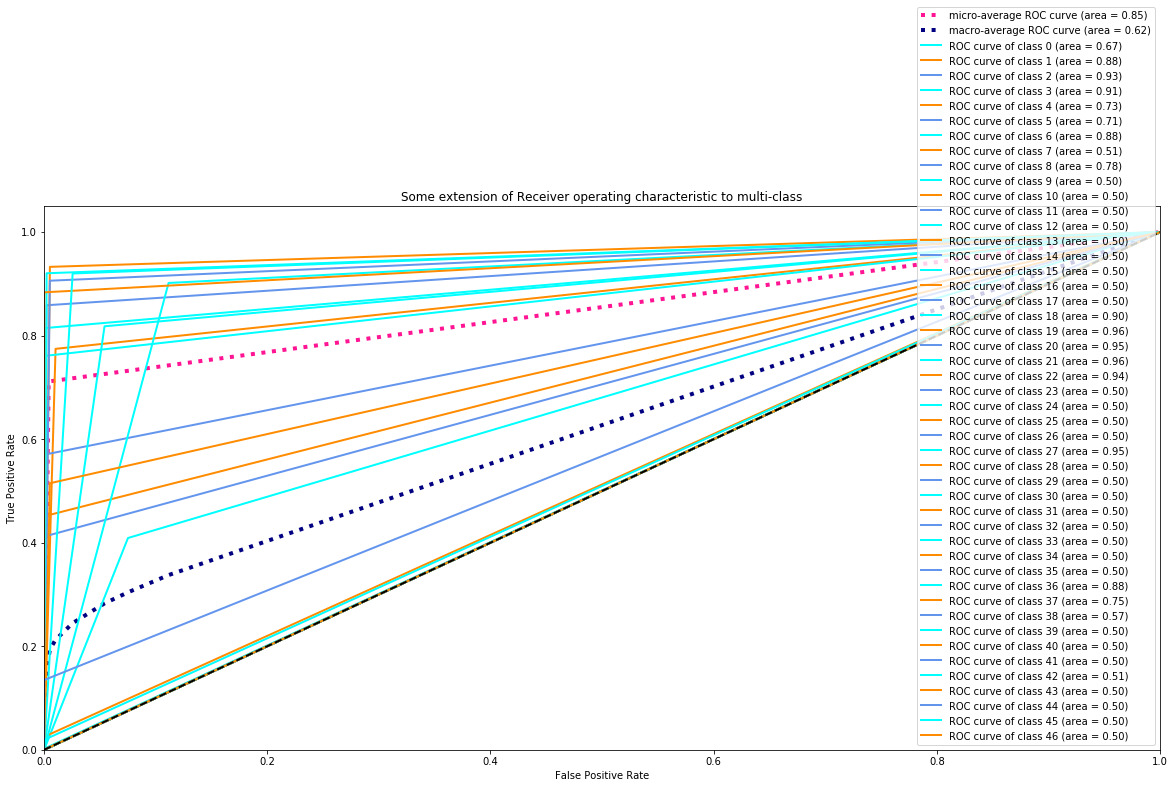

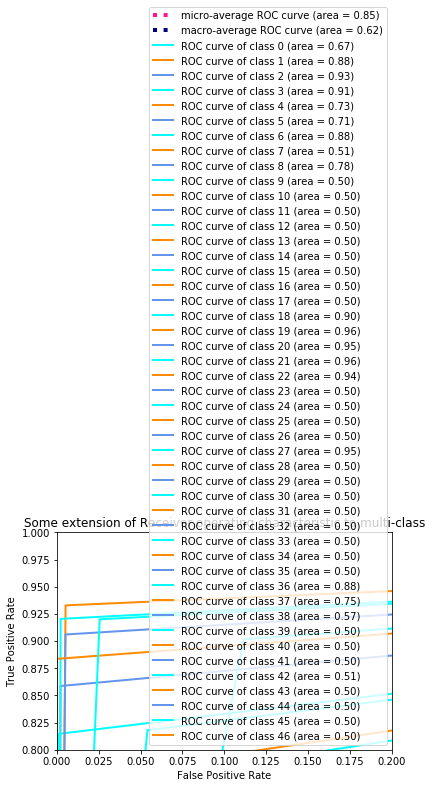

In [81]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
plt.figure(figsize = (20,10))

# Compute ROC curve and ROC area for each class
n_classes = 47
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [82]:
for i in range(n_classes):
    lkey = encoder.classes_[i]
    lcount = labels_dict.get(lkey)
    print("%s,%.3f" % (lkey, roc_auc[i]))

rmt_title,0.667
rmt_suite,0.882
rmt_standard,0.928
rmt_deluxe,0.907
rmt_bedroom,0.725
rmt_studio,0.706
rmt_superior,0.880
rmt_apartment,0.513
rmt_triple,0.785
rmt_premium,0.501
rmt_quadruple,0.500
rmt_villa,0.500
rmt_bungalow,0.500
rmt_cottage,0.500
rmt_single,0.500
rmt_dorm,0.500
rmt_non_suite,0.500
rmt_residence,0.500
rmt_room,0.895
bdt_king,0.964
bdt_double,0.950
bdt_queen,0.959
bdt_twin,0.942
bdt_single,0.500
bdt_full,0.500
bdc_more,0.500
rmc_more,0.500
prmf_free_breakfast,0.947
prmf_half_board,0.500
prmf_welcome_item,0.500
prmf_all_inclusive,0.500
prmf_full_board,0.500
prmf_free_dinner,0.500
rtf_other_item_or_credit_included,0.500
rtf_fee_included,0.500
rtf_free_parking,0.500
rmf_no_smoking,0.882
rmf_accessible,0.755
rmf_extra_bedding,0.567
rmf_smoking,0.501
rmf_balcony,0.500
rmf_terrace,0.500
rmv_good,0.510
rmv_better,0.500
rmv_standard,0.500
rmv_best,0.500
rmv_non,0.500


## Confusion matrix

We can visually check the confusion matrix to understand the distribution of misclassifications.

In [158]:
encoder.classes_
LABELS = list(encoder.classes_)

# predict_results = room_estimator.predict(predict_train_input_fn, predict_keys=LABELS)
predict_results = room_estimator.predict(predict_train_input_fn)

In [159]:
list_predictions = list(predict_results)

In [ ]:
print(list_predictions[0])

In [ ]:
# https://scikit-learn.org/dev/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]


# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(LABELS, list(room_estimator.predict(predict_train_input_fn)))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

y_true = np.array([[0,0,1], [1,1,0],[0,1,0]])
y_pred = np.array([[0,0,1], [1,0,1],[1,0,0]])

labels = ["A", "B", "C"]

conf_mat_dict={}

for label_col in range(len(labels)):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    conf_mat_dict[labels[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)


for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    print(matrix)
    

In [ ]:
# Original
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(train_df["polarity"], 
                           get_predictions(estimator, predict_train_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

# Further improvements

1. **Regression on sentiment**: we used a classifier to assign each example into a polarity class. But we actually have another categorical feature at our disposal - sentiment. Here classes actually represent a scale and the underlying value (positive/negative) could be well mapped into a continuous range. We could make use of this property by computing a regression ([DNN Regressor](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNRegressor)) instead of a classification ([DNN Classifier](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNClassifier)).
2. **Larger module**: for the purposes of this tutorial we used a small module to restrict the memory use. There are modules with larger vocabularies and larger embedding space that could give additional accuracy points.
3. **Parameter tuning**: we can improve the accuracy by tuning the meta-parameters like the learning rate or the number of steps, especially if we use a different module. A validation set is very important if we want to get any reasonable results, because it is very easy to set-up a model that learns to predict the training data without generalizing well to the test set.
4. **More complex model**: we used a module that computes a sentence embedding by embedding each individual word and then combining them with average. One could also use a sequential module (e.g. [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/2) module) to better capture the nature of sentences. Or an ensemble of two or more TF-Hub modules.
5. **Regularization**: to prevent overfitting, we could try to use an optimizer that does some sort of regularization, for example [Proximal Adagrad Optimizer](https://www.tensorflow.org/api_docs/python/tf/train/ProximalAdagradOptimizer).


# Advanced: Transfer learning analysis

Transfer learning makes it possible to **save training resources** and to achieve good model generalization even when **training on a small dataset**. In this part, we will demonstrate this by training with two different TF-Hub modules:

* **[nnlm-en-dim128](https://tfhub.dev/google/nnlm-en-dim128/1)** - pretrained text embedding module,
* **[random-nnlm-en-dim128](https://tfhub.dev/google/random-nnlm-en-dim128/1)** - text embedding module that has same vocabulary and network as **nnlm-en-dim128**, but the weights were just randomly initialized and never trained on real data.

And by training in two modes: 

* training **only the classifier** (i.e. freezing the module), and 
* training the **classifier together with the module**.

Let's run a couple of trainings and evaluations to see how using a various modules can affect the accuracy.

In [83]:
def train_and_evaluate_with_module(hub_module, train_module=False):
  embedded_text_feature_column = hub.text_embedding_column(
      key="room_name", module_spec=hub_module, trainable=train_module)

  estimator = tf.estimator.DNNEstimator(
    head=multi_label_head,
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))
    
#         model_dir='./tmp'
    
#     estimator = tf.estimator.DNNClassifier(
#       hidden_units=[500, 100],
#       feature_columns=[embedded_text_feature_column],
#       n_classes=num_classes,
#       optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

  estimator.train(input_fn=train_input_fn, steps=1000)

  train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
  test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

  training_set_accuracy = train_eval_result["auc"]
  test_set_accuracy = test_eval_result["auc"]

  return {
      "Training accuracy": training_set_accuracy,
      "Test accuracy": test_set_accuracy
  }


results = {}
results["nnlm-en-dim128"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1")
results["nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1", True)
results["random-nnlm-en-dim128"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1")
results["random-nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1", True)
results["universal-sentence-encoder"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/universal-sentence-encoder/2")
results["universal-sentence-encoder-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/universal-sentence-encoder/2", True)

Let's look at the results.

In [85]:
pd.DataFrame.from_dict(results, orient="index")

,Training accuracy,Test accuracy
nnlm-en-dim128,0.685827,0.684723
nnlm-en-dim128-with-module-training,0.701588,0.700086
random-nnlm-en-dim128,0.908356,0.907587
random-nnlm-en-dim128-with-module-training,0.901766,0.901049
universal-sentence-encoder,0.681524,0.680213
universal-sentence-encoder-with-module-training,0.693147,0.691864


We can already see some patterns, but first we should establish the baseline accuracy of the test set - the lower bound that can be achieved by outputting only the label of the most represented class:

In [ ]:
room_estimator.evaluate(input_fn=predict_test_input_fn)["accuracy_baseline"]

Assigning the most represented class will give us accuracy of **50%**. There are a couple of things to notice here:

1. Maybe surprisingly, **a model can still be learned on top of fixed, random embeddings**. The reason is that even if every word in the dictionary is mapped to a random vector, the estimator can separate the space purely using its fully connected layers.
2. Allowing training of the module with **random embeddings** increases both training and test accuracy as oposed to training just the classifier.
3. Training of the module with **pre-trained embeddings** also increases both accuracies. Note however the overfitting on the training set. Training a pre-trained module can be dangerous even with regularization in the sense that the embedding weights no longer represent the language model trained on diverse data, instead they converge to the ideal representation of the new dataset.